# Data Ingestion – Tabular Formats

In [86]:
from src.setup import *

In [2]:
%load_ext rpy2.ipython

In [3]:
%%capture --no-stdout err
%%R
library(tidyverse)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


System has not been booted with systemd as init system (PID 1). Can't operate.
Failed to connect to bus: Host is down


## Tidying Up

In [4]:
students = pd.read_csv('data/students-scores.csv')
students

,Last Name,First Name,4th Grade,5th Grade,6th Grade
0,Johnson,Mia,A,B+,A-
1,Lopez,Liam,B,B,A+
2,Lee,Isabella,C,C-,B-
3,Fisher,Mason,B,B-,C+
4,Gupta,Olivia,B,A+,A
5,Robinson,Sophia,A+,B-,A


In [5]:
# Generic conversion of letter grades to numbers
def num_score(x):
    to_num = {'A+': 4.3, 'A': 4, 'A-': 3.7,
              'B+': 3.3, 'B': 3, 'B-': 2.7,
              'C+': 2.3, 'C': 2, 'C-': 1.7}
    return x.map(lambda x: to_num.get(x, x))

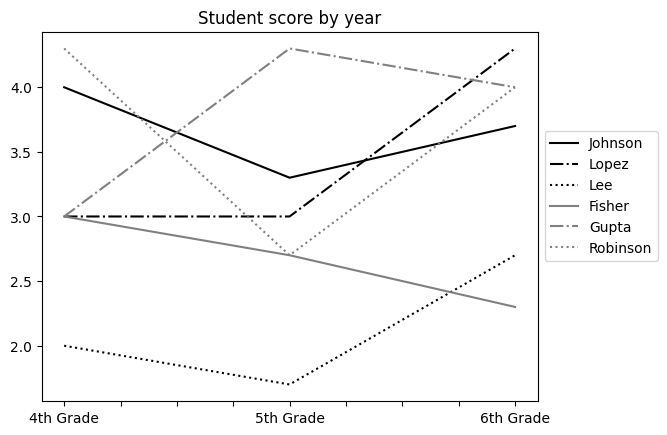

In [6]:
(students
     .set_index('Last Name')
     .drop('First Name', axis=1)
     .apply(num_score)
     .T
     .plot(title="Student score by year")
     .legend(bbox_to_anchor=(1, .75))
)
plt.savefig("img/(Ch01)Student score by year");

In [7]:
students.melt(
    id_vars=["Last Name", "First Name"], 
    var_name="Level",
    value_name="Score"
).set_index(['First Name', 'Last Name', 'Level'])

,,,Score
First Name,Last Name,Level,
Mia,Johnson,4th Grade,A
Liam,Lopez,4th Grade,B
Isabella,Lee,4th Grade,C
Mason,Fisher,4th Grade,B
...,...,...,...
Isabella,Lee,6th Grade,B-
Mason,Fisher,6th Grade,C+
Olivia,Gupta,6th Grade,A
Sophia,Robinson,6th Grade,A


In [8]:
%%capture --no-stdout err
%%R
library('tidyverse')

studentsR <- read_csv('data/students-scores.csv')
studentsR

Rows: 6 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (5): Last Name, First Name, 4th Grade, 5th Grade, 6th Grade

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
# A tibble: 6 × 5
  `Last Name` `First Name` `4th Grade` `5th Grade` `6th Grade`
  <chr>       <chr>        <chr>       <chr>       <chr>      
1 Johnson     Mia          A           B+          A-         
2 Lopez       Liam         B           B           A+         
3 Lee         Isabella     C           C-          B-         
4 Fisher      Mason        B           B-          C+         
5 Gupta       Olivia       B           A+          A          
6 Robinson    Sophia       A+          B-          A          


In [9]:
%%capture --no-stdout err
%%R
studentsR <- read_csv('data/students-scores.csv')
studentsR %>% 
  pivot_longer(c(`4th Grade`, `5th Grade`, `6th Grade`), 
               names_to = "Level", 
               values_to = "Score")

Rows: 6 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (5): Last Name, First Name, 4th Grade, 5th Grade, 6th Grade

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
# A tibble: 18 × 4
   `Last Name` `First Name` Level     Score
   <chr>       <chr>        <chr>     <chr>
 1 Johnson     Mia          4th Grade A    
 2 Johnson     Mia          5th Grade B+   
 3 Johnson     Mia          6th Grade A-   
 4 Lopez       Liam         4th Grade B    
 5 Lopez       Liam         5th Grade B    
 6 Lopez       Liam         6th Grade A+   
 7 Lee         Isabella     4th Grade C    
 8 Lee         Isabella     5th Grade C-   
 9 Lee         Isabella     6th Grade B-   
10 Fisher      Mason        4th Grade B    
11 Fisher      Mason        5th Grade B-   
12 Fisher      Mason        6th Grade C+   
13 Gupta       Olivia       4th

## CSV

### Sanity Checks

In [10]:
# Use try/except to avoid full traceback in example
try:
    pd.read_csv('data/big-random.csv')
except Exception as err:
    print_err(err)

ParserError
Error tokenizing data. C error: Expected 6 fields in line 75, saw 8


In [11]:
%%bash
# What is the general size/shape of this file?
wc data/big-random.csv

 100000  100000 4335846 data/big-random.csv


In [12]:
%%bash
cat data/big-random.csv | 
    tr -d -c ',\n' | 
    awk '{ print length; }' | 
    sort | 
    uniq -c

     46 3
  99909 5
     45 7


In [13]:
%%bash
grep -C1 -nP '^([^,]+,){7}' data/big-random.csv | head

74-squarcerai,45,quiescenze,12,scuoieremo,70
75:fantasmagorici,28,immischiavate,44,schiavizzammo,97,sfilzarono,49
76-interagiste,50,repentagli,72,attendato,95
--
712-resettando,58,strisciato,46,insaldai,62
713:aspirasse,15,imbozzimatrici,70,incanalante,93,succhieremo,41
714-saccarometriche,18,stremaste,12,hindi,19
--
8096-squincio,16,biascicona,93,solisti,70
8097:rinegoziante,50,circoncidiamo,83,stringavate,79,stipularono,34


In [14]:
import re
pat = re.compile(r'^([^,]+,){5}[^,]*$')
with open('data/big-random.csv') as fh:
    lines = [l.strip().split(',') 
             for l in fh if re.match(pat, l)]
pd.DataFrame(lines)

,0,1,2,3,4,5
0,infilaste,21,esemplava,15,stabaccavo,73
1,abbadaste,50,enartrosi,85,iella,54
2,frustulo,77,temporale,83,scoppianti,91
3,gavocciolo,84,postelegrafiche,93,inglesizzanti,63
...,...,...,...,...,...,...
99905,notareschi,60,paganico,64,esecutavamo,20
99906,rispranghiamo,11,schioccano,44,imbozzarono,80
99907,compone,85,disfronderebbe,19,vaporizzavo,54
99908,ritardata,29,scordare,43,appuntirebbe,24


### The Good, The Bad, and The Textual Data

**The Bad**

In [15]:
%%bash
cat data/parts.fwf

Part_No  Description              Maker               Price (USD)
12345    Wankle rotary engine     Acme Corporation    555.55
67890    Sousaphone               Marching Inc.       333.33
2468     Feather Duster           Sweeps Bros         22.22
A9922    Area 51 metal fragment   No Such Agency      9999.99

In [16]:
df = pd.read_fwf('data/parts.fwf', nrows=3)
df

,Part_No,Description,Maker,Price (USD)
0,12345,Wankle rotary engine,Acme Corporation,555.55
1,67890,Sousaphone,Marching Inc.,333.33
2,2468,Feather Duster,Sweeps Bros,22.22


In [17]:
df.dtypes

Part_No          int64
Description     object
Maker           object
Price (USD)    float64
dtype: object

In [18]:
df = pd.read_fwf('data/parts.fwf')
df

,Part_No,Description,Maker,Price (USD)
0,12345,Wankle rotary engine,Acme Corporation,555.55
1,67890,Sousaphone,Marching Inc.,333.33
2,2468,Feather Duster,Sweeps Bros,22.22
3,A9922,Area 51 metal fragment,No Such Agency,9999.99


In [19]:
df.dtypes  # type of `Part_No` changed

Part_No         object
Description     object
Maker           object
Price (USD)    float64
dtype: object

In [20]:
%%capture --no-stdout err
%%R
read_table('data/parts.fwf')


── Column specification ────────────────────────────────────────────────────────
cols(
  Part_No = col_character(),
  Description = col_character(),
  Maker = col_character(),
  Price = col_character(),
  `(USD)` = col_character()
)

# A tibble: 4 × 5
  Part_No Description Maker    Price  `(USD)` 
  <chr>   <chr>       <chr>    <chr>  <chr>   
1 12345   Wankle      rotary   engine Acme    
2 67890   Sousaphone  Marching Inc.   333.33  
3 2468    Feather     Duster   Sweeps Bros    
4 A9922   Area        51       metal  fragment


In [21]:
%%R
read_table('data/parts.fwf', 
           n_max = 3, 
           col_types = cols("i", "-", "f", "n"))

# A tibble: 3 × 3
  Part_No Maker    Price
    <int> <fct>    <dbl>
1   12345 rotary      NA
2   67890 Marching    NA
3    2468 Duster      NA


row   col  expected    actual             file
  1 Price a number  engine    'data/parts.fwf'
  1 NA    4 columns 7 columns 'data/parts.fwf'
  2 Price a number  Inc.      'data/parts.fwf'
  2 NA    4 columns 5 columns 'data/parts.fwf'
  3 Price a number  Sweeps    'data/parts.fwf'
... ..... ......... ......... ................
See problems(...) for more details.

In addition: Warning message:
Unnamed `col_types` should have the same length as `col_names`. Using smaller of the two. 


In [22]:
%%bash
# Notice many date formats
cat data/parts.tsv

Part_No	Description	Date	Price (USD)
12345	Wankle rotary	2020-04-12T15:53:21	555.55
67890	Sousaphone	April 12, 2020	333.33
2468	Feather Duster	4/12/2020	22.22
A9922	Area 51 metal	04/12/20	9999.99


In [23]:
# Let Pandas make guesses for each row
# VERY SLOW for large tables
parts = pd.read_csv('data/parts.tsv', 
                    sep='\t', parse_dates=['Date'])
parts

,Part_No,Description,Date,Price (USD)
0,12345,Wankle rotary,2020-04-12T15:53:21,555.55
1,67890,Sousaphone,"April 12, 2020",333.33
2,2468,Feather Duster,4/12/2020,22.22
3,A9922,Area 51 metal,04/12/20,9999.99


In [24]:
parts.dtypes

Part_No         object
Description     object
Date            object
Price (USD)    float64
dtype: object

**The Good**

In [25]:
# Generated data files with random values
from glob import glob
# Use glob() function to identify files matching pattern
glob('data/multicsv/2000-*.csv')[:8] # ... and more

['data/multicsv/2000-01-16.csv',
 'data/multicsv/2000-01-25.csv',
 'data/multicsv/2000-01-21.csv',
 'data/multicsv/2000-01-19.csv',
 'data/multicsv/2000-01-01.csv',
 'data/multicsv/2000-01-22.csv',
 'data/multicsv/2000-01-30.csv',
 'data/multicsv/2000-01-13.csv']

In [26]:
import dask.dataframe as dd
df = dd.read_csv('data/multicsv/2000-*-*.csv', 
                 parse_dates=['timestamp'])
print("Total rows:", len(df))
df.head()

Total rows: 2592000


,timestamp,id,name,x,y
0,2000-01-01 00:00:00,979,Zelda,0.802163,0.166619
1,2000-01-01 00:00:01,1019,Ingrid,-0.349999,0.704687
2,2000-01-01 00:00:02,1007,Hannah,-0.169853,-0.050842
3,2000-01-01 00:00:03,1034,Ursula,0.868090,-0.190783
4,2000-01-01 00:00:04,1024,Ingrid,0.083798,0.109101


In [30]:
df.mean(numeric_only=True).compute()

id    999.965606
x       0.000096
y       0.000081
dtype: float64

## Spreadsheets Considered Harmful

In [31]:
# Default engine `xlrd` might have bug in Python 3.9
pd.read_excel('data/Excel-Pitfalls.xlsx',
              sheet_name="Dask Sample", engine="openpyxl")

,timestamp,id,name,x
0,2000-01-01 00:00:00,979,Zelda,0.802163
1,2000-01-01 0:00:01,1019.5,Ingrid,-0.349999
2,2000-01-01 00:00:02,1007,Hannah,-0.169853
3,2000-01-01 00:00:03,1034,Ursula,0.86809
...,...,...,...,...
6,timestamp,id,name,y
7,2000-01-01 00:00:02,1007,Hannah,-0.050842
8,2000-01-01 00:00:03,1034,Ursula,-0.190783
9,2000-01-01 00:00:04,1024,Ingrid,0.109101


In [40]:
df1 = pd.read_excel('data/Excel-Pitfalls.xlsx', 
                    nrows=5, dtype=object, engine="openpyxl")
df1.loc[:2]   # Just look at first few rows

,timestamp,id,name,x
0,2000-01-01 00:00:00,979,Zelda,0.802163
1,2000-01-01 0:00:01,1019.5,Ingrid,-0.349999
2,2000-01-01 00:00:02,1007,Hannah,-0.169853


In [41]:
pd.read_excel('data/Excel-Pitfalls.xlsx', skiprows=7, engine="openpyxl")

,timestamp,id,name,y
0,2000-01-01 00:00:02,1007,Hannah,-0.050842
1,2000-01-01 00:00:03,1034,Ursula,-0.190783
2,2000-01-01 00:00:04,1024,Ingrid,0.109101


In [42]:
df1.dtypes

timestamp    object
id           object
name         object
x            object
dtype: object

In [43]:
# Look at the stored data type of each cell
tss = df1.loc[:2, 'timestamp']
for i, ts in enumerate(tss):
    print(f"TS {i}: {ts}\t{ts.__class__.__name__}")

TS 0: 2000-01-01 00:00:00	datetime
TS 1: 2000-01-01 0:00:01	str
TS 2: 2000-01-01 00:00:02	datetime


In [44]:
pd.to_datetime(tss)

0   2000-01-01 00:00:00
1   2000-01-01 00:00:01
2   2000-01-01 00:00:02
Name: timestamp, dtype: datetime64[ns]

In [45]:
# Look at the stored data type of each cell
ids = df1.loc[:3, 'id']
for i, id_ in enumerate(ids):
    print(f"id {i}: {id_}\t{id_.__class__.__name__}")

id 0: 979	int
id 1: 1019.5	float
id 2: 1007	int
id 3: 1034	str


In [46]:
ids.astype(int)

0     979
1    1019
2    1007
3    1034
Name: id, dtype: int64

In [47]:
# Only rows through index `3` are useful
# We are casting to more specific data types 
#   based on domain and problem knowledge
df1 = df1.loc[0:3].astype(
    {'id': np.uint16, 
     'name': pd.StringDtype(), 
     'x': float})
# datetimes require conversion function, not just type
df1['timestamp'] = pd.to_datetime(df1.timestamp)
print(df1.dtypes)

timestamp    datetime64[ns]
id                   uint16
name         string[python]
x                   float64
dtype: object


In [48]:
df1.set_index('timestamp')

,id,name,x
timestamp,,,
2000-01-01 00:00:00,979,Zelda,0.802163
2000-01-01 00:00:01,1019,Ingrid,-0.349999
2000-01-01 00:00:02,1007,Hannah,-0.169853
2000-01-01 00:00:03,1034,Ursula,0.868090


## SQL RDBMS

### Massaging Data Types

In [68]:
con, engine = connect_local()

In [56]:
make_dask_data()

In [70]:
"Put some data into postgres.  Assumes Dask data was generated"
out = io.StringIO()
df = pd.read_csv('data/dask/2000-01-02.csv', parse_dates=['timestamp'])
df = df.loc[3456:5678]
df.to_sql('dask_sample', engine, if_exists='replace')
sql = """
    ALTER TABLE dask_sample
    ALTER COLUMN id TYPE smallint,
    ALTER COLUMN name TYPE char(10),
    ALTER COLUMN x TYPE decimal(6, 3),
    ALTER COLUMN y TYPE real,
    ALTER COLUMN index TYPE integer;
    """
cur = con.cursor()
cur.execute(sql)
cur.execute('COMMIT;')
describe = """
    SELECT column_name, data_type, numeric_precision, character_maximum_length
    FROM information_schema.columns 
    WHERE table_name='dask_sample';"""
cur.execute(describe)
for tup in cur:
    print(f"{tup[0]}: {tup[1]} ({tup[2] or tup[3]})", file=out)
cur.execute("SELECT count(*) FROM dask_sample")
print("Rows:", cur.fetchone()[0], file=out)

In [71]:
# Function connect_local() spelled out in chapter 4 (Anomaly Detection)
con, engine = connect_local()
cur = con.cursor()
cur.execute("SELECT * FROM dask_sample")
pprint(cur.fetchmany(2))

[(3456,
  datetime.datetime(2000, 1, 2, 0, 57, 36),
  'Zelda     ',
  1017,
  Decimal('-0.489'),
  -0.61577815),
 (3457,
  datetime.datetime(2000, 1, 2, 0, 57, 37),
  'Ray       ',
  1094,
  Decimal('-0.782'),
  0.7568845)]


In [72]:
df = pd.read_sql('dask_sample', engine, index_col='index')
df.tail(3)

,timestamp,name,id,x,y
index,,,,,
5676,2000-01-02 01:34:36,Laura,1030,-0.918,0.293872
5677,2000-01-02 01:34:37,Victor,980,-0.620,0.963750
5678,2000-01-02 01:34:38,Alice,985,0.132,0.706138


In [73]:
df.dtypes

timestamp    datetime64[ns]
name                 object
id                    int64
x                   float64
y                   float64
dtype: object

In [74]:
cur.execute("SELECT * FROM dask_sample")
cur.description

(Column(name='index', type_code=23),
 Column(name='timestamp', type_code=1114),
 Column(name='name', type_code=1042),
 Column(name='id', type_code=21),
 Column(name='x', type_code=1700),
 Column(name='y', type_code=700))

In [75]:
rows = cur.fetchall()
[type(v) for v in rows[0]]

[int, datetime.datetime, str, int, decimal.Decimal, float]

In [76]:
# Read the data with no imposed data types
df = pd.DataFrame(rows, 
                  columns=[col.name for col in cur.description],
                  dtype=object)

# Assign specific int or float lengths to some fields
types = {'index': np.int32, 'id': np.int16, 'y': np.float32}
df = df.astype(types)

# Cast the Python datetime to a Pandas datetime
df['timestamp'] = pd.to_datetime(df.timestamp)
df.set_index('index').head(3)

,timestamp,name,id,x,y
index,,,,,
3456,2000-01-02 00:57:36,Zelda,1017,-0.489,-0.615778
3457,2000-01-02 00:57:37,Ray,1094,-0.782,0.756885
3458,2000-01-02 00:57:38,Wendy,986,-0.471,0.983392


In [77]:
df.dtypes

index                 int32
timestamp    datetime64[ns]
name                 object
id                    int16
x                    object
y                   float32
dtype: object

In [78]:
pprint({repr(x): x.__class__.__name__ 
        for x in df.reset_index().iloc[0]})

{"'Zelda     '": 'str',
 "Decimal('-0.489')": 'Decimal',
 "Timestamp('2000-01-02 00:57:36')": 'Timestamp',
 'np.float32(-0.61577815)': 'float32',
 'np.int16(1017)': 'int16',
 'np.int32(3456)': 'int32',
 'np.int64(0)': 'int64'}


### Repeating in R

In [79]:
%%capture --no-stdout err
%%R
require("RPostgreSQL")
drv <- dbDriver("PostgreSQL")
con <- dbConnect(drv, dbname = "dirty",
                 host = "localhost", port = 5432,
                 user = "cleaning", password = "data")
sql <- "SELECT id, name, x, y FROM dask_sample LIMIT 3"
data <- tibble(dbGetQuery(con, sql))
data

# A tibble: 3 × 4
     id name              x      y
  <int> <chr>         <dbl>  <dbl>
1  1017 "Zelda     " -0.489 -0.616
2  1094 "Ray       " -0.782  0.757
3   986 "Wendy     " -0.471  0.983


In [82]:
%%capture --no-stdout err
%%R
sql <- "SELECT max(x) AS max_x, max(y) AS max_y, 
name, count(name) 
FROM dask_sample 
WHERE id > 1050 
GROUP BY name 
ORDER BY count(name) DESC
LIMIT 12;"
# Here we simply retrieve a data.frame 
# rather than convert to tibble 
dbGetQuery(con, sql)

    max_x     max_y       name count
1   0.957 0.9741784 Michael        8
2   0.514 0.5175206 Kevin          8
3   0.840 0.8458282 Xavier         7
4   0.887 0.7497735 Charlie        6
5   0.879 0.5652965 Alice          6
6   0.990 0.7184983 Laura          5
7  -0.292 0.8931112 Patricia       5
8   0.557 0.8699002 Zelda          5
9   0.561 0.9357566 Jerry          5
10  0.456 0.7619607 Norbert        5
11  0.435 0.7568845 Ray            5
12  0.870 0.2510659 Hannah         5


### Where SQL Goes Wrong (And How to Notice It)

In [88]:
"Create deliberately truncated data"
out = io.StringIO()
df = pd.read_csv('data/AMTRAK-Stations-Database_2012.csv')
df = df[['Code', 'StationName', 'City', 'State']]
df['Visitors'] = np.random.randint(0, 35_000, 973)
df['StationName'] = df.StationName.str.split(', ', expand=True)[0]
df['StationName'] = df.StationName.str[:20]
df['Visitors'] = np.clip(df.Visitors, 0, 2**15-1)
df.to_sql('bad_amtrak', engine, if_exists='replace', index=False)
sql = """
    ALTER TABLE bad_amtrak
    ALTER COLUMN "StationName" TYPE char(20),
    ALTER COLUMN "Visitors" TYPE smallint;    
    """
cur = con.cursor()
cur.execute(sql)
cur.execute('COMMIT;')
describe = """
    SELECT column_name, data_type, numeric_precision, character_maximum_length
    FROM information_schema.columns 
    WHERE table_name='bad_amtrak';"""
cur.execute(describe)
for tup in cur:
    print(f"{tup[0]}: {tup[1]} ({tup[2] or tup[3]})", file=out)
cur.execute("SELECT count(*) FROM bad_amtrak")
print("Rows:", cur.fetchone()[0], file=out)

In [89]:
amtrak = pd.read_sql('bad_amtrak', engine)
amtrak.head()

,Code,StationName,City,State,Visitors
0,ABB,Abbotsford-Colby,Colby,WI,14835
1,ABE,Aberdeen,Aberdeen,MD,19738
2,ABN,Absecon,Absecon,NJ,21518
3,ABQ,Albuquerque,Albuquerque,NM,2978
4,ACA,Antioch-Pittsburg,Antioch,CA,20042


In [90]:
amtrak['StationName'] = amtrak.StationName.str.strip()
hist = amtrak.StationName.str.len().value_counts().sort_index()
hist

StationName
4      15
5      46
6     100
7     114
     ... 
17     15
18     17
19     27
20    116
Name: count, Length: 17, dtype: int64

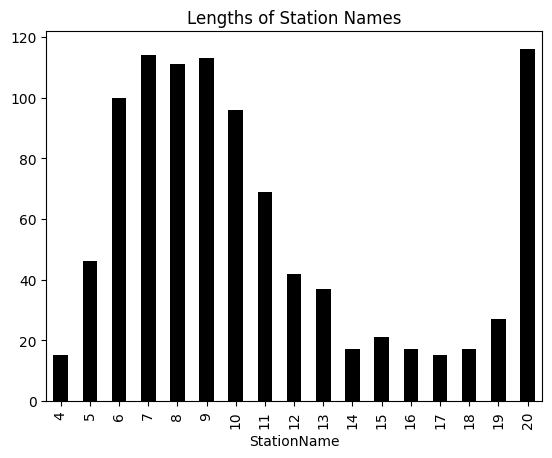

In [91]:
hist.plot(kind='bar', 
          title="Lengths of Station Names")
plt.savefig('img/(Ch01)Lengths of Station Names')

In [92]:
amtrak[amtrak.StationName.str.len() == 20]

,Code,StationName,City,State,Visitors
28,ARI,Astoria (Shell Stati,Astoria,OR,28456
31,ART,Astoria (Transit Cen,Astoria,OR,31366
42,BAL,Baltimore (Penn Stat,Baltimore,MD,27105
50,BCA,Baltimore (Camden St,Baltimore,MD,32767
...,...,...,...,...,...
965,YOC,Yosemite - Curry Vil,Yosemite National Park,CA,32753
966,YOF,Yosemite - Crane Fla,Yosemite National Park,CA,19839
969,YOV,Yosemite - Visitor C,Yosemite National Park,CA,32767
970,YOW,Yosemite - White Wol,Yosemite National Park,CA,763


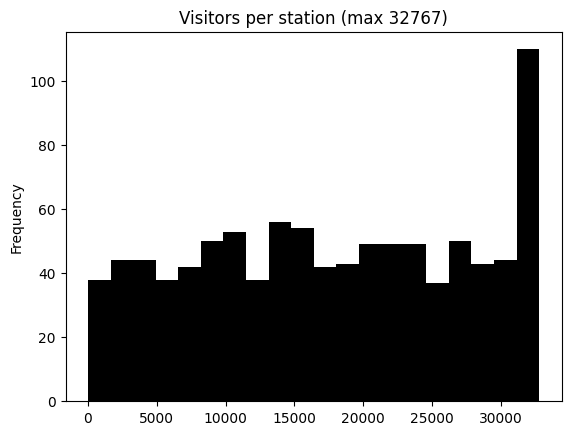

In [93]:
max_ = amtrak.Visitors.max()
amtrak.Visitors.plot(
        kind='hist', bins=20, 
        title=f"Visitors per station (max {max_})")
plt.savefig(f"img/(Ch01)Visitors per station (max {max_})")

In [94]:
ints = pd.Series(
    [100, 200, 15_000, 50_000, -15_000, -50_000])
ints.astype(np.int16)

0      100
1      200
2    15000
3   -15536
4   -15000
5    15536
dtype: int16

## Other Formats

### HDF5 and NetCDF-4

#### Tools and Libraries

In [96]:
!pip install h5py

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 9.7 MB/s eta 0:00:00:00:010:01


In [97]:
import h5py
h5fname = ('data/earthdata/OMI-Aura_ANC-OMVFPITMET'
           '_2020m0216t225854-o82929_v003'
           '-2020m0217t090311.nc4')

data = h5py.File(h5fname, mode='r')

for name, arr in data.items():
    print(f"{name:6s} | {str(arr.shape):14s} | "
          f"{str(arr.dtype):7s} | {arr.attrs['units'][0]}")

line   | (1494,)        | int16   | 1
lev    | (47,)          | int16   | 1
sample | (60,)          | int16   | 1
lat    | (1494, 60)     | float32 | degrees_north
lon    | (1494, 60)     | float32 | degrees_east
time   | (1494,)        | float64 | seconds since 1993-01-01 00:00:00
DELP   | (1494, 60, 47) | float32 | Pa
PS     | (1494, 60)     | float32 | Pa
PHIS   | (1494, 60)     | float32 | m+2 s-2
T      | (1494, 60, 47) | float32 | K
U      | (1494, 60, 47) | float32 | m s-1
V      | (1494, 60, 47) | float32 | m s-1
U10M   | (1494, 60)     | float32 | m s-1
V10M   | (1494, 60)     | float32 | m s-1
PBLTOP | (1494, 60)     | float32 | Pa
TROPPB | (1494, 60)     | float32 | Pa


In [98]:
# A 3-D block from middle of DELP array
middle = data['V'][::500, 10:12, :3]
middle

array([[[17.032158  , 12.763597  ,  3.7710803 ],
        [16.53227   , 12.759642  ,  4.1722884 ]],

       [[ 4.003829  , -1.0843939 , -6.7918572 ],
        [ 3.818467  , -1.0030019 , -6.6708655 ]],

       [[-2.7798688 ,  0.24923703, 20.513933  ],
        [-2.690715  ,  0.2226392 , 20.473366  ]]], dtype=float32)

In [99]:
middle.mean(axis=1)

array([[16.782215  , 12.76162   ,  3.9716845 ],
       [ 3.911148  , -1.0436978 , -6.7313614 ],
       [-2.735292  ,  0.23593812, 20.493649  ]], dtype=float32)

In [100]:
%%R -i h5fname
library(rhdf5)
h5ls(h5fname)

   group   name       otype  dclass            dim
0      /   DELP H5I_DATASET   FLOAT 47 x 60 x 1494
1      / PBLTOP H5I_DATASET   FLOAT      60 x 1494
2      /   PHIS H5I_DATASET   FLOAT      60 x 1494
3      /     PS H5I_DATASET   FLOAT      60 x 1494
4      /      T H5I_DATASET   FLOAT 47 x 60 x 1494
5      / TROPPB H5I_DATASET   FLOAT      60 x 1494
6      /      U H5I_DATASET   FLOAT 47 x 60 x 1494
7      /   U10M H5I_DATASET   FLOAT      60 x 1494
8      /      V H5I_DATASET   FLOAT 47 x 60 x 1494
9      /   V10M H5I_DATASET   FLOAT      60 x 1494
10     /    lat H5I_DATASET   FLOAT      60 x 1494
11     /    lev H5I_DATASET INTEGER             47
12     /   line H5I_DATASET INTEGER           1494
13     /    lon H5I_DATASET   FLOAT      60 x 1494
14     / sample H5I_DATASET INTEGER             60
15     /   time H5I_DATASET   FLOAT           1494


In [101]:
%%R -i h5fname
V = h5read(h5fname, 'V')
V[1:2, 10:12, 10:11]

, , 1

         [,1]     [,2]     [,3]
[1,] 17.69524 17.23481 16.57238
[2,] 12.46370 12.44905 12.47155

, , 2

         [,1]     [,2]     [,3]
[1,] 17.71876 17.25898 16.56942
[2,] 12.42049 12.40599 12.43139



In [102]:
make_h5_hierarchy()  # initialize the HDF5 file
f = h5py.File('data/hierarchy.h5', 'r+')
dset = f['/deeply/nested/group/my_data']
print(dset.shape, dset.dtype)

(10, 10, 10, 10) int32


In [103]:
for key, val in dset.attrs.items():
    print(key, "→", val)
print()
print("Data block:\n", dset[5, 3, 2:4, 8:])

author → David Mertz
citation → Cleaning Data Book
shape_type → 4-D integer array

Data block:
 [[-93 -53]
 [ 18 -37]]


In [104]:
dset[5, 3, 2:4, 8:] = np.random.randint(-99, 99, (2, 2))
print(dset[5, 3, 2:4, 8:])
f.close()                   # write change to disk

[[-45 -76]
 [-96 -21]]


In [105]:
%%R 
library(rhdf5)
h5ls('data/hierarchy.h5')

                   group      name       otype  dclass               dim
0                      /    deeply   H5I_GROUP                          
1                /deeply    nested   H5I_GROUP                          
2         /deeply/nested     group   H5I_GROUP                          
3   /deeply/nested/group   my_data H5I_DATASET INTEGER 10 x 10 x 10 x 10
4                /deeply      path   H5I_GROUP                          
5           /deeply/path elsewhere   H5I_GROUP                          
6 /deeply/path/elsewhere     other H5I_DATASET INTEGER                20
7           /deeply/path that_data H5I_DATASET   FLOAT             5 x 5


### SQLite

In [106]:
import sqlite3
db = sqlite3.connect('data/affinity.sqlite')
cur = db.cursor()
cur.execute("SELECT a, b, c FROM t1")
for row in cur:
    print([f"{x.__class__.__name__} {x}" for x in row])

['int 123', 'str 456', 'float 789.0']
['str xyz', 'str 3.14', 'float 2.71']


### Apache Parquet

In [110]:
! pip install pyarrow fastparquet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.7/40.7 MB 13.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 13.2 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 10.4 MB/s eta 0:00:00a 0:00:01


In [107]:
%%bash
ls -x data/multicsv.parq

_common_metadata  _metadata	   part.0.parquet   part.10.parquet
part.11.parquet   part.12.parquet  part.13.parquet  part.14.parquet
part.15.parquet   part.16.parquet  part.17.parquet  part.18.parquet
part.19.parquet   part.1.parquet   part.20.parquet  part.21.parquet
part.22.parquet   part.23.parquet  part.24.parquet  part.25.parquet
part.26.parquet   part.27.parquet  part.28.parquet  part.29.parquet
part.2.parquet	  part.3.parquet   part.4.parquet   part.5.parquet
part.6.parquet	  part.7.parquet   part.8.parquet   part.9.parquet


In [112]:
pd.read_parquet('data/multicsv.parq/')

,timestamp,id,name,x,y
index,,,,,
0,2000-01-01 00:00:00,979,Zelda,0.802163,0.166619
1,2000-01-01 00:00:01,1019,Ingrid,-0.349999,0.704687
2,2000-01-01 00:00:02,1007,Hannah,-0.169853,-0.050842
3,2000-01-01 00:00:03,1034,Ursula,0.868090,-0.190783
...,...,...,...,...,...
86396,2000-01-10 23:59:56,998,Jerry,0.589575,0.412477
86397,2000-01-10 23:59:57,1011,Yvonne,0.047785,-0.202337
86398,2000-01-10 23:59:58,1053,Oliver,0.690303,-0.639954
86399,2000-01-10 23:59:59,1009,Ursula,0.228775,0.750066


## Data Frames

### Spark/Scala

### Pandas and Derived Wrappers

In [113]:
import dask.dataframe as dd
dfd = dd.read_csv('data/multicsv/*.csv', parse_dates=['timestamp'])

In [114]:
(dfd
   .loc[dfd.x > dfd.y+1,            # Row predicate
        ['name', 'x']]              # Column list
   .groupby("name")                 # Grouping column(s)
   .mean()                          # Aggregation
   .rename(columns={'x': 'Mean_x'}) # Naming
   .nsmallest(5, 'Mean_x')          # Selection by order
).compute()                         # Concretize

,Mean_x
name,
Ray,0.662570
Ursula,0.662811
Xavier,0.664117
Wendy,0.664238
Kevin,0.664836


### Vaex

In [ ]:
import vaex
dfv = vaex.read_csv_and_convert('data/multicsv/*.csv', copy_index=False)

In [69]:
print(
dfv
   [dfv.x > dfv.y + 1]  # Predicate selection of rows
   [['name', 'x']]      # List selection of columns
   .groupby('name')     # Grouping
   .agg({'x': 'mean'})  # Aggregation
   .sort('x')           # Sort (Vaex does not have .nsmallest() method)
   .head(5)             # First 5
)

  #  name           x
  0  Ray     0.66257
  1  Ursula  0.662811
  2  Xavier  0.664117
  3  Wendy   0.664238
  4  Kevin   0.664836


In [127]:
%%bash
rm -f data/multicsv/*.hdf5

### Data Frames in R (Tidyverse)

In [120]:
%%R 
files <- dir(path = "data/multicsv/", pattern = "*.csv", full.names = TRUE)
read_csv_quiet <- function(file) { 
    read_csv(file, col_types = cols("T", "n", "f", "n", "n"), progress = FALSE) }

data <- files   %>%
  # read_csv() on each file, reduce to one DF with rbind
  map(read_csv_quiet) %>%  
  # If this were genuinely large data, we would process each file individually
  reduce(rbind)  

data

# A tibble: 2,592,000 × 5
   timestamp              id name         x       y
   <dttm>              <dbl> <fct>    <dbl>   <dbl>
 1 2000-01-01 00:00:00   979 Zelda   0.802   0.167 
 2 2000-01-01 00:00:01  1019 Ingrid -0.350   0.705 
 3 2000-01-01 00:00:02  1007 Hannah -0.170  -0.0508
 4 2000-01-01 00:00:03  1034 Ursula  0.868  -0.191 
 5 2000-01-01 00:00:04  1024 Ingrid  0.0838  0.109 
 6 2000-01-01 00:00:05   955 Ingrid -0.757   0.308 
 7 2000-01-01 00:00:06   968 Laura   0.230  -0.913 
 8 2000-01-01 00:00:07   945 Ursula  0.265  -0.271 
 9 2000-01-01 00:00:08  1020 Victor  0.512  -0.481 
10 2000-01-01 00:00:09   992 Wendy   0.862  -0.599 
# ℹ 2,591,990 more rows
# ℹ Use `print(n = ...)` to see more rows


In [121]:
%%R 
info <- capture.output( 
# --- hide nonsense on STDERR
summary <- data   %>% 
  filter(x > y+1) %>%   # Predicate selection of rows
  select(name, x) %>%   # Selection of columns
  group_by(name)  %>%   # Grouping
                        # Aggregation and naming
  summarize(Mean_x = mean(x)) %>% 
  arrange(Mean_x) %>%   # Sort data
  head(5)               # First 5
# --- end of block for capture.output
,type = "message")   

summary

# A tibble: 5 × 2
  name   Mean_x
  <fct>   <dbl>
1 Ray     0.663
2 Ursula  0.663
3 Xavier  0.664
4 Wendy   0.664
5 Kevin   0.665


### Data Frames in R (data.table)

In [122]:
%%R
info <- capture.output( 
# --- hide nonsense on STDERR
library(data.table)
# --- end of block for capture.output
,type = "message")   

dt <- data.table(data)
summary <- dt[
    i = x > y + 1,      # Predicate selection of rows
                        # Aggregation and naming
    j = .(Mean_x = mean(x)), 
    by = .(name)]       # Grouping

# Sort data and first 5
summary[order(Mean_x), .SD[1:5]]

     name    Mean_x
   <fctr>     <num>
1:    Ray 0.6625697
2: Ursula 0.6628107
3: Xavier 0.6641165
4:  Wendy 0.6642382
5:  Kevin 0.6648363


### Bash for Fun

In [123]:
%%bash
COND='{if ($4 > $5+1) print}'
SHOW='{for(j in count) print j,sum[j]/count[j]}'
AGG='{ count[$1]++; sum[$1]+=$2 }'" END $SHOW"

cat data/multicsv/*.csv | # Create the "data frame"
  grep -v ^timestamp    | # Remove the headers
  awk -F, "$COND"       | # Predicate selection
  cut -d, -f3,4         | # Select columns
  awk -F, "$AGG"        | # Aggregate by group
  sort -k2              | # Sort data
  head -5                 # First 5

Ray 0.66257
Ursula 0.662811
Xavier 0.664117
Wendy 0.664238
Kevin 0.664836
